# Machine Learning - Project 2:
# _Autoencoder for mathematical modeling of blood flow in a stenosis context_

## Context

In this project, we continue our study on this notebook by focusing on LSTM Autoencoder using the same dataset generated on the jupyter notebook `main.ipynb`.

Abbreviations used:
- $N_u$ = total number of spatial points per simulation
- $N_t$ = total number of time steps per simulation
- $N_s$ = total number of simulations

## Table of contents

[1. Data exploration](#data_exploration) 
- [Imports](#1imports)
- [Pathways](#1pathways)
- [Loading](#1load)
- [Exploration](#1exploration)

[2. Data preprocessing](#preprocessing)

[3. Pickle](#pickle)

[4. LSTM Autoencoder](#autoencoder)

### Imports  <a name="1imports"></a>

In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from helpers import *
from preprocessing import *
from sklearn.model_selection import train_test_split
from LSTM import *
from crossvalidation_lstm import *
import _pickle as cPickle
%load_ext autoreload
%autoreload 2
torch.manual_seed(0)
np.random.seed(1)
seed = 1

## 1. Data exploration  <a name="data_exploration"></a>

### Pathways <a name="1pathways"></a>

In [2]:
DATA_PATH = 'data/'
DATA_Ux_PATH = DATA_PATH + 'u1_very_small.csv.bz2'
DATA_Uy_PATH = DATA_PATH + 'u2_very_small.csv.bz2'

### Loading <a name="1load"></a>

Let's load the data which consists of 2 matrices Ux, Uy denoting the x and y coordinates of the speed.

In [3]:
# Loading
Ux_pd = pd.read_csv(DATA_Ux_PATH, header=None)
Uy_pd = pd.read_csv(DATA_Uy_PATH, header=None)
# Converting from dataframe to numpy
Ux = Ux_pd.to_numpy()
Uy = Uy_pd.to_numpy()

### Exploration <a name="1exploration"></a>

Let's have a closer look at our imported data sets. The columns represent the time steps and the rows represent a point of our blood vessel mesh and each 5509 row a new simulation.

In [4]:
print("Our input array Ux is of shape:",Ux.shape)
print("Our input array Uy is of shape:",Uy.shape)
print("Printing a row of Ux:", '\n', Ux[10,:], '\n')
print("Printing a row of Uy:", '\n', Uy[10,:], '\n')

Our input array Ux is of shape: (137725, 110)
Our input array Uy is of shape: (137725, 110)
Printing a row of Ux: 
 [0.0694243  0.27537487 0.60389834 1.02538242 1.49979277 1.9813229
 2.42318455 2.78232553 3.02371067 3.12378595 3.22605803 3.32166836
 3.41249686 3.49946177 3.58301614 3.66339786 3.74073801 3.81511138
 3.88656184 3.95511576 4.02078945 4.08359325 4.14353388 4.20061589
 4.2548424  4.30621561 4.35473712 4.40040807 4.44322934 4.48320158
 4.52032526 4.55460075 4.58602833 4.61460821 4.64034055 4.66322547
 4.68326307 4.70045341 4.71479655 4.72629252 4.73494137 4.7407431
 4.74369775 4.74423086 4.74375285 4.74246986 4.74042825 4.73764939
 4.73414407 4.72991811 4.7249748  4.71931611 4.71294324 4.70585693
 4.6980577  4.68954587 4.68032167 4.67038525 4.65973675 4.64837623
 4.63630377 4.6235194  4.61002317 4.5958151  4.5808952  4.5652635
 4.54892001 4.53186473 4.51409767 4.49561883 4.47642823 4.45652585
 4.43591171 4.41458581 4.39254814 4.36979872 4.34633752 4.32216457
 4.29727986 4.27

For the rest of the analysis, we need to figure out the number of simulation step. As we know that we previsouly generated 25 simulations on Matlab and all the new simulations are appended row-wise, we can deduce it with the following computation.

In [5]:
positions =5509 #We know it from the matlab code
times = Ux.shape[1]
simulations = int(Ux.shape[0]/positions)
print("We ran ", simulations, "simulations with different parameters for each simulation (parameters of the stenosis and resistance of the blood flow in the bifurcations)")
print("1 simulation calculate the velocities of the blood flow at ", positions, " different positions and at ", times, " different times")

We ran  25 simulations with different parameters for each simulation (parameters of the stenosis and resistance of the blood flow in the bifurcations)
1 simulation calculate the velocities of the blood flow at  5509  different positions and at  110  different times


## 2. Data preprocessing  <a name="preprocessing"></a>

Let's check if we have any NaN or None values in our dataframe.

In [6]:
print(np.count_nonzero(np.isnan(Ux)))
print(np.count_nonzero(np.isnan(Uy)))

0
0


It seems there are no None values so we can start direclty preprocess our datasets.

Let's sample our data points into the following ratios : 

In [7]:
ratio_pts = 0.01
ratio_time = 1

new_Ux, new_Uy, new_inds = sample(Ux, Uy, ratio_pts, ratio_time)
print(new_Ux.shape, new_Uy.shape)

(1375, 110) (1375, 110)


In [8]:
new_Nu, new_Nt = get_Nu_Nt_sampled(Ux, new_Ux)

print('With the sampling we got from ', 5509, ' positions to ', new_Nu, ' positions')
print('With the sampling we got from ', 110, ' time steps to ', new_Nt, ' time steps')

With the sampling we got from  5509  positions to  55  positions
With the sampling we got from  110  time steps to  110  time steps


We can look at the positions of the sampled positions to make sure that we cover mostly all the important parts of the geometry of the artery :

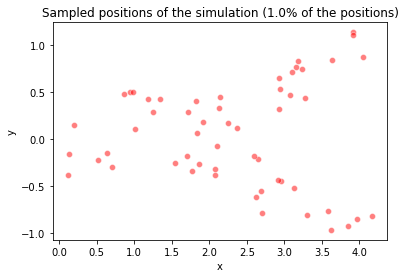

In [9]:
plot_sampled_coord(new_inds) 

Let's flatten our matrices into a 2D matrices with dimensions $((2 N_u),  N_t, N_s)$. For each simulation, the x and y speed coordinates are compressed to the following 1D matrix:



$$
\mathbf{M_{2D}}
=
\begin{bmatrix}
\vdots & \vdots & \vdots & \vdots \\
u_{x}^{(0)} & u_{x}^{(1)} & \cdots &
u_{x}^{(N_t - 1)} \\
\vdots & \vdots & \ddots & \vdots \\
u_{y}^{(0)} & u_{y}^{(1)} & \cdots &
u_{y}^{(N_t - 1)} \\
\vdots & \vdots & \vdots & \vdots
\end{bmatrix}
$$

In [10]:
flattened_array = flatten_2d(new_Ux, new_Uy, ratio_pts)
flattened_array.shape

(25, 110, 110)

Let's make a sanity check that the dimension of 1 datapoint is indeed ${2 * new_{N_t} * new_{N_u})}$

In [ ]:
assert flattened_array.shape[1] == 2*new_Nt*new_Nu

print(2*new_Nt*new_Nu)

## 3. Pickle  <a name="pickle"></a>

To avoid the loading and processing steps each time we open the notebook, we will save the processed matrix "flattened_array" using pickle : 

In the following cell, we will create pickles for every subsampled data according to the ratios_pts and the ratios_t :

In [ ]:
'''
ratios_pts = [0.1, 0.05, 0.02]
ratios_t = [0.5, 0.25, 0.1]

create_subsamples(Ux, Uy, ratios_pts, ratios_t, name_file='very_small')
'''

The cell above is only intented to be run __once__.

#### Start from here if you the pickle file already exist in your data folder

Change only the following cell to change the name of the file you want to open :

In [ ]:
ratios = [0.1, 0.5]
size = ['very_small', 'small', 'large']

name = 'processed_'+str(size[0])+'_'+str(ratios[0])+'_'+str(ratios[1])

print('name of the file you want to read : ', name)

In [ ]:
flattened_array  = cPickle.load(open("data/pickle/"+str(size[0])+"/"+name, "rb"))

In [ ]:
print(flattened_array)

##### Final step : split train/test

We split the data set into a training a testing set to be able to evaluate our autoencoder.

In [14]:
x_train, x_test = train_test_split(flattened_array, test_size=0.1, random_state=seed)
y_train, y_test = x_train, x_test

print(x_train.shape)
print(x_test.shape)

(22, 110, 110)
(3, 110, 110)


## 4. LSTM Auto-encoder  <a name="autoencoder"></a>

In [15]:
input_dim = 110
model = LSTMAE(input_dim, hidden_size=5)

In [16]:
model

LSTMAE(
  (encoder): Encoder(
    (lstm_encoder): LSTM(110, 5, batch_first=True)
  )
  (decoder): Decoder(
    (lstm_decoder): LSTM(5, 5, batch_first=True)
    (fc): Linear(in_features=5, out_features=110, bias=True)
  )
)

In [17]:
# define network parameters
learningRate=1e-2
epochs=50
input_size=x_train.shape[1]
k_folds = 5

# creates a criterion that measures the mean squared error (squared L2 norm) 
criterion = nn.MSELoss() 

--------------------------------
FOLD 0
--------------------------------
Epoch:1/50 Training Error:8.450 Test Error:4.963
Epoch:2/50 Training Error:8.365 Test Error:4.897
Epoch:3/50 Training Error:8.244 Test Error:4.804
Epoch:4/50 Training Error:8.122 Test Error:4.710
Epoch:5/50 Training Error:7.988 Test Error:4.609
Epoch:6/50 Training Error:7.834 Test Error:4.493
Epoch:7/50 Training Error:7.677 Test Error:4.372
Epoch:8/50 Training Error:7.510 Test Error:4.248
Epoch:9/50 Training Error:7.341 Test Error:4.125
Epoch:10/50 Training Error:7.182 Test Error:4.008
Epoch:11/50 Training Error:7.037 Test Error:3.903
Epoch:12/50 Training Error:6.904 Test Error:3.809
Epoch:13/50 Training Error:6.780 Test Error:3.722
Epoch:14/50 Training Error:6.665 Test Error:3.642
Epoch:15/50 Training Error:6.561 Test Error:3.572
Epoch:16/50 Training Error:6.467 Test Error:3.510
Epoch:17/50 Training Error:6.382 Test Error:3.457
Epoch:18/50 Training Error:6.308 Test Error:3.413
Epoch:19/50 Training Error:6.244 Tes

Epoch:10/50 Training Error:6.829 Test Error:3.344
Epoch:11/50 Training Error:6.663 Test Error:3.274
Epoch:12/50 Training Error:6.526 Test Error:3.210
Epoch:13/50 Training Error:6.422 Test Error:3.148
Epoch:14/50 Training Error:6.352 Test Error:3.096
Epoch:15/50 Training Error:6.306 Test Error:3.041
Epoch:16/50 Training Error:6.291 Test Error:2.997
Epoch:17/50 Training Error:6.301 Test Error:2.958
Epoch:18/50 Training Error:6.331 Test Error:2.924
Epoch:19/50 Training Error:6.373 Test Error:2.894
Epoch:20/50 Training Error:6.430 Test Error:2.868
Epoch:21/50 Training Error:6.496 Test Error:2.846
Epoch:22/50 Training Error:6.565 Test Error:2.827
Epoch:23/50 Training Error:6.634 Test Error:2.812
Epoch:24/50 Training Error:6.706 Test Error:2.799
Epoch:25/50 Training Error:6.768 Test Error:2.788
Epoch:26/50 Training Error:6.833 Test Error:2.779
Epoch:27/50 Training Error:6.893 Test Error:2.772
Epoch:28/50 Training Error:6.934 Test Error:2.767
Epoch:29/50 Training Error:6.986 Test Error:2.762


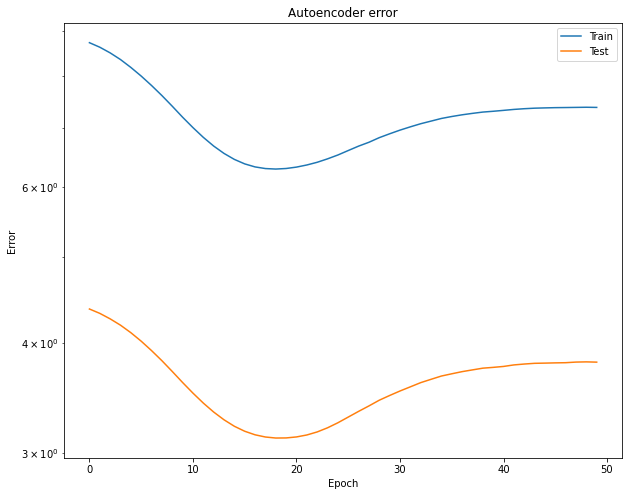

3.801728380036503

In [20]:
Kfold_lstm(x_train, k_folds, input_size, epochs, criterion, learningRate, hidden_size=5)

#### Parameters tuning

Find the best learning rate of our model using cross-validation :

In [25]:
# define network parameters
learning_rates =[0.1, 0.05, 0.01] #[0.1, 0.05, 0.01, 0.005, 0.001]
epochs= 1 #50
input_size=x_train.shape[1]
k_folds = 5
dataset_name = "very_small" #Only used to save the plot with the good name
hidden_size = 5

# creates a criterion that measures the mean squared error (squared L2 norm) 
criterion = nn.MSELoss()  

Learning rate =  0.1

Performance of 5 fold cross validation: 
Average Training Error: 7.896 	 Average Test Error: 3.950
 
Learning rate =  0.05

Performance of 5 fold cross validation: 
Average Training Error: 8.412 	 Average Test Error: 4.209
 
Learning rate =  0.01

Performance of 5 fold cross validation: 
Average Training Error: 8.750 	 Average Test Error: 4.377
 

Best learning rate is  0.1  with a best error of :  3.950040928427876



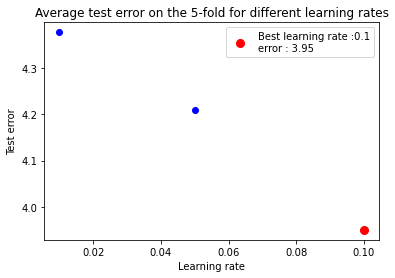

In [26]:
best_result, best_lr = tuning_lr_lstm(x_train, k_folds, input_size, epochs, criterion, learning_rates, hidden_size, dataset_name_=dataset_name)

Find the best number of neurons in the latent space (neurons in the "middle layer of the auto-encoder") in the auto-encoder (which is actually the dimension of the compressed data) : 

In [27]:
# define network parameters
lr = best_lr # from above
epochs= 1 #50
input_size=x_train.shape[1]
k_folds = 5
number_neurons = [3, 5] #[3, 5, 6, 8, 10]
dataset_name = "very_small" #Only used to save the plot with the good name

# creates a criterion that measures the mean squared error (squared L2 norm) 
criterion = nn.MSELoss()  

Number of neurons =  3

Performance of 5 fold cross validation: 
Average Training Error: 7.896 	 Average Test Error: 3.950
 
Number of neurons =  5

Performance of 5 fold cross validation: 
Average Training Error: 7.896 	 Average Test Error: 3.950
 
The results obtained for the number of latent neurons tested are the following : [3.950040928427876, 3.950040928427876].
The best average test error obtained is 3.950040928427876, and it is obtained with 3 neurons in the latent layer.


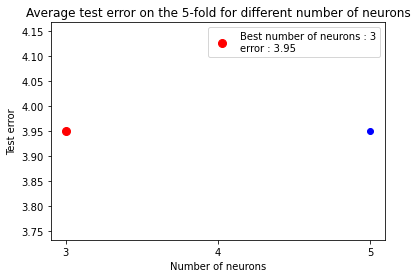

In [31]:
best_result, best_neurons_nb = tuning_latent_layer_lstm(x_train, k_folds, input_size, epochs, criterion, lr, number_neurons, hidden_size, dataset_name_=dataset_name)

#### Quality of the compression on the test set using the tuned parameters :

In [ ]:
#Do it for current dataset with nice plot and all

The above cell is great for vizualisation, but now we can do it for the different subsamples dataset, see the report to see the nice comparison table :

In [ ]:
import glob
import os 
import _pickle as cPickle

file_location = os.path.join('data', 'pickle', 'very_small', '*')

filenames = glob.glob(file_location)

i=0 
for f in filenames:
    #Load the data
    x  = cPickle.load(open(f, "rb"))
    
    #Split
    x_train, x_test = train_test_split(x, test_size=0.1, random_state=seed)
    y_train, y_test = x_train, x_test
    
    #Training
    #je vous laisse completer je vous sens plus chaud là dessus mdr
    
    #Testing
    #pareil mdr

## 6. Discussion & conclusion